In [44]:
# Only to use if Jupyter Notebook
# %load_ext google.datalab.kernel

In [45]:
from __future__ import division
import os, hashlib, math
import numpy as np
import pandas as pd

import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt

import google.datalab.contrib.mlworkbench.commands
import google.datalab.ml as ml

This Notebook shows you how to perform the basic steps in order to build, train and deploy a model on Google Cloud Platform using ML Toolbox

1. Collect data
2. Organize data
3. Design the model
4. Train and generate the model
5. Deploy the model

Note that we will build, train and deploy our model on this machine only as our dataset is small enough and a model created locally can still be deployed on Google ML Engine.

In [46]:
WORKING_FOLDER = 'resolutiontime'
CSV_FILE = "issues.csv"

In [47]:
!rm -rf $WORKING_FOLDER
!mkdir $WORKING_FOLDER

# 1 of 7 - Collect data
In a use case like this, data can be collected in different ways usually through dump of your database or export from your CRM into CSV. 

The data that we have collected is available on Google Cloud Storage as gs://solutions-public-assets/smartenup-helpdesk/ml/data.csv (public dataset).

Note that in some cases, data might be saved in BigQuery (which is both a storage and queryuing engine) which is perfectly fine and would actually facilitate the filtering of the data specially with big datasets.

In [48]:
# Copy data from the cloud to this instance
!gsutil cp gs://solutions-public-assets/smartenup-helpdesk/ml/issues.csv $CSV_FILE

Copying gs://solutions-public-assets/smartenup-helpdesk/ml/issues.csv...
/ [1 files][  6.5 MiB/  6.5 MiB]                                                
Operation completed over 1 objects/6.5 MiB.                                      


In [49]:
# Read data from csv into a Panda dataframe
df_data = pd.read_csv(CSV_FILE, dtype=str)
print '%d rows' % len(df_data)
df_data.head()

100000 rows


,ticketid,contactid,seniority,experience,category,type,impact,priority,resolutiontime
0,t0,Patrick Blevins,12,3-Advanced,Performance,Request,4-Critical,P1,5
1,t1,Kaitlyn Ruiz,3,2-Experienced,Technical,Issue,1-Minor,P4,6
2,t2,Chelsea Martin,11,2-Experienced,Technical,Request,4-Critical,P1,2
3,t3,Richard Arnold,8,2-Experienced,Performance,Request,1-Minor,P3,5
4,t4,Kelly Jackson,7,4-Trainer,Billing,Request,0-Unclassified,P4,3


We need to make sure that we do not have any duplicate. If that was the case some identical rows could be found in the training set and validation set for example which would have an impact on the model training (remember, validation and training set can't overlap)

In [50]:
df_data = df_data.drop_duplicates(df_data.columns.difference(['ticketid']))
print '%d rows' % len(df_data)

99993 rows


# 2 of 7 - Organize data

## Filter data

We keep only the columns that we are interested and discard some others:
- ownerid because we won't know its value when doing a prediction
- priority as it is a value that we will predict in another Notebook
- statisfaction as it is not a value that we know when doing a prediction. It might also be a value we woud like to predict later

In [51]:
def transform_data(df):
    # Lists the column names that we want to keep from our dataframe. 
    interesting_columns = ['ticketid', 'seniority', 'experience', 'category', 'type', 'impact', 'resolutiontime']
    
    # Filters the dataframe to keep only the relevant data and return the dataframe.
    df = df[interesting_columns]
    return df
  
df_data = transform_data(df_data)
# Displays the new dataframe.
print '%d rows' % len(df_data)
df_data.head()

99993 rows


,ticketid,seniority,experience,category,type,impact,resolutiontime
0,t0,12,3-Advanced,Performance,Request,4-Critical,5
1,t1,3,2-Experienced,Technical,Issue,1-Minor,6
2,t2,11,2-Experienced,Technical,Request,4-Critical,2
3,t3,8,2-Experienced,Performance,Request,1-Minor,5
4,t4,7,4-Trainer,Billing,Request,0-Unclassified,3


## Create datasets
Here we create training and test datasets on a 80/20 basis. To keep consistency for every load of data we use a column that follows these two requirements:
- Is a unique identifer for each row
- Will not be used as a training input

ticketid is a good candidate

In [52]:
def is_test_set(identifier, test_ratio, hash):
    h = int(hash(identifier.encode('ascii')).hexdigest()[-7:], 16)
    return (h/0xFFFFFFF) < test_ratio
    
def create_datasets(df, id_column, test_ratio=0.2, hash=hashlib.md5):
    ids = df[id_column]
    ids_test_set = ids.apply(lambda x: is_test_set(x, test_ratio, hash))
    return df.loc[~ids_test_set], df.loc[ids_test_set]

df_train, df_eval = create_datasets(df_data, 'ticketid')

In [53]:
# Set paths for CSV datasets
training_data_path = './{}/train.csv'.format(WORKING_FOLDER)
test_data_path = './{}/eval.csv'.format(WORKING_FOLDER)

# Write Panda Dataframes to CSV files
df_train.to_csv(training_data_path, header=False, index=False)
df_eval.to_csv(test_data_path, header=False, index=False)

## Explore
One of the most important part of Machine Learning is to explore the data before building a model. A few things will help improving your model quality such as
- Normalization
- Look at feature correlation
- Feature crossing
- ...

Because the main goal of this Notebook and solution is to show how to build and deploy a model for serverless enrichment, we won't spend too much time here (also because the provided dataset is fake) but keep in mind that this is not a part that should be ignored in a real world example.

# 3 of 7: Analyse
ML Workbench comes with a pre-buit function that analyzes training data and generate stats, such as min/max/mean for numeric values, vocabulary for text columns. Note that if cloud is set to True, the function leverages BigQuery making the switch from small dataset to big data seamless.

In [59]:
!rm -rf ./resolutiontime/analysis

In [60]:
%%ml dataset create
format: csv
train: ./resolutiontime/train.csv
eval: ./resolutiontime/eval.csv
name: issues_data_resolutiontime
schema:
    - name: ticketid
      type: STRING
    - name: seniority
      type: FLOAT
    - name: experience
      type: STRING
    - name: category
      type: STRING
    - name: type
      type: STRING
    - name: impact
      type: STRING
    - name: resolutiontime
      type: FLOAT

In [61]:
%%ml analyze
output: ./resolutiontime/analysis
data: $issues_data_resolutiontime
features:
  ticketid: 
    transform: key
  seniority:
    transform: identity
  experience:
    transform: one_hot
  category:
    transform: one_hot
  type:
    transform: one_hot
  impact:
    transform: one_hot
  resolutiontime:
    transform: target


Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/notebooks/resolutiontime/train.csv...
file /content/datalab/notebooks/resolutiontime/train.csv analyzed.


# 4 of 7: Transform
This section is optional but can be an important step when dealing with big data. While the Analysis phase provides enough details for the training step to append, the transform phase creates tfRecord files which is required for Tensorflow processing. Doing it now make sure that the training step can start from the preprocessed data and does not have to do this for each row for every pass of the data which is not recommended when handling text or image data.

In [62]:
!rm -rf ./resolutiontime/transform

In [63]:
%%ml transform
output: ./resolutiontime/transform
analysis: ./resolutiontime/analysis
data: $issues_data_resolutiontime

In [64]:
%%ml dataset create
format: transformed
name: issues_data_resolutiontime_transformed
train: ./resolutiontime/transform/train-*
eval: ./resolutiontime/transform/eval-*

# 5 of 7 Train
This steps leverages Tensorflow canned models in the background without you having to write any code.

In [65]:
!rm -rf ./resolutiontime/train

In [66]:
%%ml train
output: ./resolutiontime/train
analysis: ./resolutiontime/analysis
data: $issues_data_resolutiontime_transformed
model_args:
    model: dnn_regression
    max-steps: 2000
    hidden-layer-size1: 32
    hidden-layer-size2: 8
    train-batch-size: 100
    eval-batch-size: 100
    learning-rate: 0.001

TensorBoard was started successfully with pid 10210. Click here to access it.

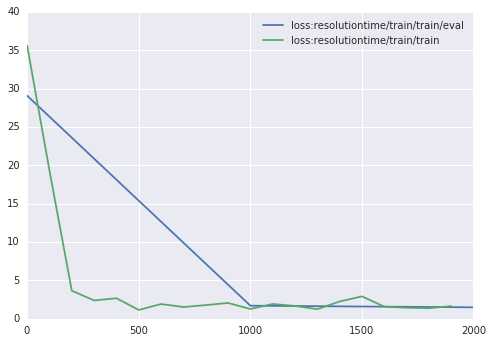

In [68]:
from google.datalab.ml import Summary

summary = Summary('{}/train'.format(WORKING_FOLDER))
summary.plot('loss')

In [ ]:
tensorboard_pid = ml.TensorBoard.start('./{}/train'.format(WORKING_FOLDER))

In [70]:
ml.TensorBoard.stop(tensorboard_pid)

# 6 of 7
In this section, we will test our model to see how well it performs. For demo purposes, we are reusing the evaluation dataset. Consider using a 3rd separated dataset for production cases.

In [71]:
!rm -rf ./resolutiontime/evalme

In [72]:
%%ml batch_predict
model: ./resolutiontime/train/evaluation_model/
output: ./resolutiontime/evalme
format: csv
data:
  csv: ./resolutiontime/eval.csv

local prediction...
INFO:tensorflow:Restoring parameters from ./resolutiontime/train/evaluation_model/variables/variables
done.


In [73]:
!ls ./resolutiontime/evalme

predict_results_eval.csv  predict_results_schema.json


In [75]:
df_check = pd.read_csv('./{}/evalme/predict_results_eval.csv'.format(WORKING_FOLDER), names=['predicted', 'target', 'tid'])
df_check.head()

,predicted,target,tid
0,2.16742,1.0,t9
1,3.60892,3.0,t15
2,7.70469,8.0,t25
3,2.06665,2.0,t27
4,3.45178,5.0,t31


In [76]:
mse = metrics.mean_squared_error(df_check['target'], df_check['predicted'])
rmse = math.sqrt(mse)
print 'Root Mean Squared Error: %.3f' % rmse

Root Mean Squared Error: 1.223


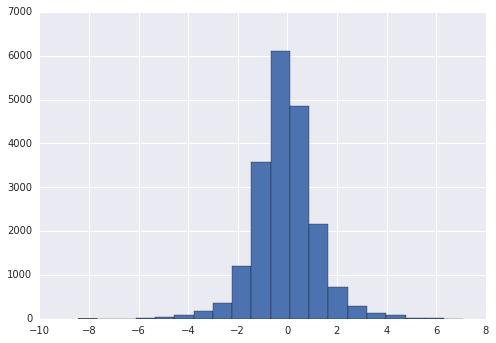

In [77]:
df_check['error'] = df_check['predicted'] - df_check['target']
_ = plt.hist(df_check['error'], bins=20)

We see on this Histogram that most of the values are in between -2 and 2 which is acceptable in our use case where we try to predict how many hours a ticket will remain open. Note that we did not do any feature engineering either. Results might improve by doing extra prepration steps such as:
- Feature crossing
- Correlation analysis
- Normalization

# 7 of 7  - Deploy the Model

In [ ]:
model_name = 'mdl_helpdesk_resolution_time'
model_version = 'v1'

storage_bucket = 'gs://' + datalab.Context.default().project_id + '-datalab-workspace/'
storage_region = 'us-central1'

In [ ]:
# Check that we have the model files created by the training
!ls -R train/model

In [ ]:
# Create a model
!gcloud ml-engine models create {model_name} --regions {storage_region}

In [ ]:
# Create a staging bucket required to write staging files
# When creating a model from local files
staging_bucket = 'gs://' + datalab.Context.default().project_id + '-dtlb-staging-resolution'
!gsutil mb -c regional -l {storage_region} {staging_bucket}

In [ ]:
# Create our version of the model.
!gcloud ml-engine versions create {model_version} --model {model_name} --origin train/model --staging-bucket {staging_bucket}

That version that is deployed is the one that you will be able to update automatically in a production environment if you need to update your model daily/weekly/monthly for example